#Import

In [1]:
import pandas as pd
import string
import nltk

!pip install --upgrade plotly
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
import numpy as np
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn import metrics

     |████████████████████████████████| 27.7 MB 51.4 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


#Stopwords Remove

In [2]:
def remove_stopwords(text,lang,domain_stopwords=[]):
  
  stop_words = nltk.corpus.stopwords.words(lang) # lang='portuguese' or lang='english'
  
  s = str(text).lower() # tudo para caixa baixa
  table = str.maketrans({key: None for key in string.punctuation})
  s = s.translate(table) # remove pontuacao
  tokens = word_tokenize(s) #obtem tokens
  v = [i for i in tokens if not i in stop_words and not i in domain_stopwords and not i.isdigit()] # remove stopwords
  s = ""
  for token in v:
    s += token+" "
  return s.strip()

#Stemming

In [3]:
def stemming(text,lang):
  
  stemmer = PorterStemmer() # stemming para ingles
  
  if lang=='portuguese':
    stemmer = nltk.stem.RSLPStemmer() # stemming para portuguese
    
  tokens = word_tokenize(text) #obtem tokens
  
  sentence_stem = ''
  doc_text_stems = [stemmer.stem(i) for i in tokens]
  for stem in doc_text_stems:
    sentence_stem += stem+" "
    
  return sentence_stem.strip()

#DataBase

In [4]:
# https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

# Download
!gdown --id 1Hd0ytKZrR3s22FheUJt4EZOpZ4eWyTrN

Downloading...
From: https://drive.google.com/uc?id=1Hd0ytKZrR3s22FheUJt4EZOpZ4eWyTrN
To: /content/tweets_corona_virus.zip
100% 4.60M/4.60M [00:00<00:00, 33.2MB/s]


In [5]:
# Unzip
!unzip tweets_corona_virus.zip

Archive:  tweets_corona_virus.zip
  inflating: Corona_NLP_test.csv     
  inflating: Corona_NLP_train.csv    


In [6]:
# Load DataBase and manipulate it
dataset = pd.read_csv('Corona_NLP_train.csv',encoding='iso8859')
dataset

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [7]:
# Load DataBase and manipulate it
dataset = dataset.dropna().sample(5000)
dataset.reset_index(inplace=True,drop=True)
dataset

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,4082,49034,"Tara Hills, CA",16-03-2020,Most of us will get covid-19 in a supermarket....,Neutral
1,41120,86072,"Pembroke, Ontario, Canada",10-04-2020,Help On Wheels During COVID 19 Crisis We have ...,Positive
2,33975,78927,DMV by way of Ohio,06-04-2020,Grocery workers are dying Where s DOL More fro...,Neutral
3,8093,53045,"West Palm Beach, FL",18-03-2020,My son sent me this photo from a grocery store...,Extremely Positive
4,5415,50367,Miami,17-03-2020,#COVID19's Business and #ConsumerImpact in Eur...,Neutral
...,...,...,...,...,...,...
4995,9340,54292,"Luna, Aitken Basin",19-03-2020,Hands up who lived through the #MillenniumBug ...,Extremely Negative
4996,20613,65565,"London, England",23-03-2020,The ongoing oil price war between Russia and S...,Extremely Negative
4997,6963,51915,New York City and points West,18-03-2020,???Reminder: While you stock up on food &amp; ...,Negative
4998,35763,80715,London,07-04-2020,"Image 6 from my Deliverwho series, capturing t...",Positive


#Bag-of-Words and applying TFIDF

In [8]:
def compute_vsm_tfidf(dataset,lang,domain_stopwords=[]):
  
  d = []
  for index,row in dataset.iterrows():
    text = row['OriginalTweet'] 
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)
  
  matrix = TfidfVectorizer(max_features=700,)
  X = matrix.fit_transform(d)
  
  tfidf_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return tfidf_vect_df


vsm = compute_vsm_tfidf(dataset,'english')
vsm

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abl,access,accord,across,act,action,activ,actual,ad,add,...,worri,wors,would,wrong,ye,year,yesterday,yet,your,youâ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#K-Means

In [9]:
# Building data to K-Means

X = np.array(vsm)
length = np.sqrt((X**2).sum(axis=1))[:,None]
X = X / length
X = np.array(pd.DataFrame(X).fillna(0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Ao normalizar os vetores, podemos usar k-means com distância euclidiana. Prova:

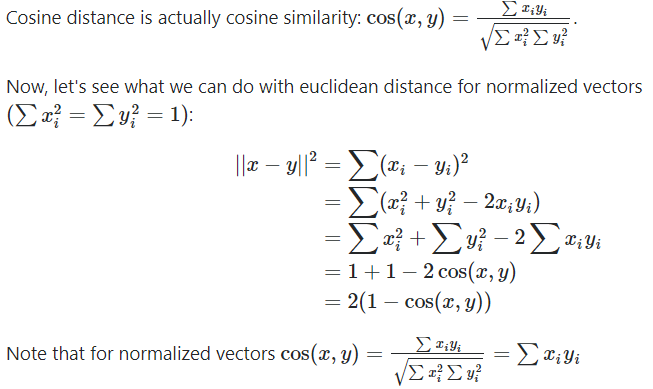

#Group Text

In [10]:
kmeans = KMeans(n_clusters=15).fit(X)

In [11]:
dataset['cluster'] = kmeans.labels_
dataset

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cluster
0,4082,49034,"Tara Hills, CA",16-03-2020,Most of us will get covid-19 in a supermarket....,Neutral,5
1,41120,86072,"Pembroke, Ontario, Canada",10-04-2020,Help On Wheels During COVID 19 Crisis We have ...,Positive,11
2,33975,78927,DMV by way of Ohio,06-04-2020,Grocery workers are dying Where s DOL More fro...,Neutral,12
3,8093,53045,"West Palm Beach, FL",18-03-2020,My son sent me this photo from a grocery store...,Extremely Positive,3
4,5415,50367,Miami,17-03-2020,#COVID19's Business and #ConsumerImpact in Eur...,Neutral,0
...,...,...,...,...,...,...,...
4995,9340,54292,"Luna, Aitken Basin",19-03-2020,Hands up who lived through the #MillenniumBug ...,Extremely Negative,9
4996,20613,65565,"London, England",23-03-2020,The ongoing oil price war between Russia and S...,Extremely Negative,6
4997,6963,51915,New York City and points West,18-03-2020,???Reminder: While you stock up on food &amp; ...,Negative,9
4998,35763,80715,London,07-04-2020,"Image 6 from my Deliverwho series, capturing t...",Positive,9


In [12]:
dataset['silhouette'] = metrics.silhouette_samples(X, kmeans.labels_)
dataset

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cluster,silhouette
0,4082,49034,"Tara Hills, CA",16-03-2020,Most of us will get covid-19 in a supermarket....,Neutral,5,0.031452
1,41120,86072,"Pembroke, Ontario, Canada",10-04-2020,Help On Wheels During COVID 19 Crisis We have ...,Positive,11,0.015138
2,33975,78927,DMV by way of Ohio,06-04-2020,Grocery workers are dying Where s DOL More fro...,Neutral,12,0.020601
3,8093,53045,"West Palm Beach, FL",18-03-2020,My son sent me this photo from a grocery store...,Extremely Positive,3,0.032246
4,5415,50367,Miami,17-03-2020,#COVID19's Business and #ConsumerImpact in Eur...,Neutral,0,0.007949
...,...,...,...,...,...,...,...,...
4995,9340,54292,"Luna, Aitken Basin",19-03-2020,Hands up who lived through the #MillenniumBug ...,Extremely Negative,9,-0.005904
4996,20613,65565,"London, England",23-03-2020,The ongoing oil price war between Russia and S...,Extremely Negative,6,0.104334
4997,6963,51915,New York City and points West,18-03-2020,???Reminder: While you stock up on food &amp; ...,Negative,9,0.016021
4998,35763,80715,London,07-04-2020,"Image 6 from my Deliverwho series, capturing t...",Positive,9,0.015819


In [13]:
# Applying silhouette we can find the representative element of each cluster
representantes = {}
for cluster in dataset.cluster.unique():
  representantes[cluster] = dataset[dataset.cluster==cluster].sort_values(by='silhouette',ascending=False).head(1).OriginalTweet.to_list()[0]

representantes

{0: 'Statement: Consumer Complaints of COVID-19 Fraud Surpass 15,000 https://t.co/0eIuqoRSCL https://t.co/rZfn7sohN0',
 1: '#Covid_19 \r\r\nRIp off prices https://t.co/FqhFFLFlSJ',
 2: '???? ??????? ??????? ???? ????? ???? ???? ?????. ??? ????? ?????? ?????? "?? ????" ????? ???? ???? ???????. https://t.co/L8bJLjotOI',
 3: '#Coronavirus: #Woolworths implements its own #social #distancing #guidelines    #supermarket  https://t.co/teBgLANzOZ',
 4: 'For those who need it.\r\r\n#CoronavirusUSA\r\r\n#coronavirus\r\r\nHomemade Hand Sanitizer: How To Make Your Own Hand Sanitizer https://t.co/BtF0PvROsU',
 5: 'From a supermarket in     19',
 6: 'A sharp reduction in oil demand owing to COVID 19 outbreak coupled with a disagreement between Opec and Russia regarding a reduction in oil output has resulted in a sharp drop in crude oil prices Read more',
 7: 'The world; panic buys food and toiletries. \r\r\n\r\r\nAmerica; panic buys food, toiletries oh and guns ?????\r\r\n\r\r\n#COVID2019 https://t.

In [14]:
L = []
for index,row in dataset.iterrows():
  L.append(representantes[row['cluster']])
dataset['representantes'] = L
dataset

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cluster,silhouette,representantes
0,4082,49034,"Tara Hills, CA",16-03-2020,Most of us will get covid-19 in a supermarket....,Neutral,5,0.031452,From a supermarket in 19
1,41120,86072,"Pembroke, Ontario, Canada",10-04-2020,Help On Wheels During COVID 19 Crisis We have ...,Positive,11,0.015138,Grocery store workers need HELP too! Let @serv...
2,33975,78927,DMV by way of Ohio,06-04-2020,Grocery workers are dying Where s DOL More fro...,Neutral,12,0.020601,Violinists Reenact Titanic at Grocery Store
3,8093,53045,"West Palm Beach, FL",18-03-2020,My son sent me this photo from a grocery store...,Extremely Positive,3,0.032246,#Coronavirus: #Woolworths implements its own #...
4,5415,50367,Miami,17-03-2020,#COVID19's Business and #ConsumerImpact in Eur...,Neutral,0,0.007949,Statement: Consumer Complaints of COVID-19 Fra...
...,...,...,...,...,...,...,...,...,...
4995,9340,54292,"Luna, Aitken Basin",19-03-2020,Hands up who lived through the #MillenniumBug ...,Extremely Negative,9,-0.005904,The has upended the all amp are in amp is the ...
4996,20613,65565,"London, England",23-03-2020,The ongoing oil price war between Russia and S...,Extremely Negative,6,0.104334,A sharp reduction in oil demand owing to COVID...
4997,6963,51915,New York City and points West,18-03-2020,???Reminder: While you stock up on food &amp; ...,Negative,9,0.016021,The has upended the all amp are in amp is the ...
4998,35763,80715,London,07-04-2020,"Image 6 from my Deliverwho series, capturing t...",Positive,9,0.015819,The has upended the all amp are in amp is the ...


#Output Data

In [15]:
# Clustering Representantes
fig = px.treemap(dataset, path=[px.Constant("Dataset"), 'cluster','representantes'])
fig.show()

In [16]:
# Sentiment

fig = px.treemap(dataset, path=[px.Constant("Dataset"), 'cluster','Sentiment'])
fig.show()

In [17]:
# Location 

fig = px.treemap(dataset, path=[px.Constant("Dataset"), 'cluster','Location'])
fig.show()